## import numpy as np
import matplotlib.pylab as plt
import scipy.signal
import time
import os

import spikeinterface.extractors as se
import spikeinterface.full as si
import spikeinterface.preprocessing as st #toolkit is not an available module... trying with preprocessing

import probeinterface as pi
from probeinterface.plotting import plot_probe, plot_probe_group

from pathlib import Path

%matplotlib  widget

In [3]:
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
print(n_jobs)
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

16


In [3]:
# npxpath = Path(r"E:\Ephys\PP_temp\E1_M2_test\2024-01-22_19-26-25") # recording 1 is a single shank test recording
npxpath = Path(r"E:\Ephys\PP_temp\E1_M6\NPXData\2024-01-23_19-19-08")
save2path = Path(os.path.join(npxpath, 'preprocessedData.zarr'))

start_time = time.time()

recording_raw = se.read_openephys(folder_path=npxpath, stream_id="0", load_sync_channel=False)
fs = recording_raw.get_sampling_frequency()
# recording_slice = recording_raw.frame_slice(start_frame=0*fs, end_frame=1*fs)
# recording = st.correct_lsb(recording_slice, verbose=1);
recording = st.correct_lsb(recording_raw, verbose=1);

Estimated LSB value: 3


In [4]:
print(recording)

ScaleRecording: 384 channels - 30.0kHz - 1 segments - 183,662,661 samples - 6,122.09s (1.70 hours) 
                int16 dtype - 131.37 GiB


Text(0.5, 0, 'noise  [microV]')

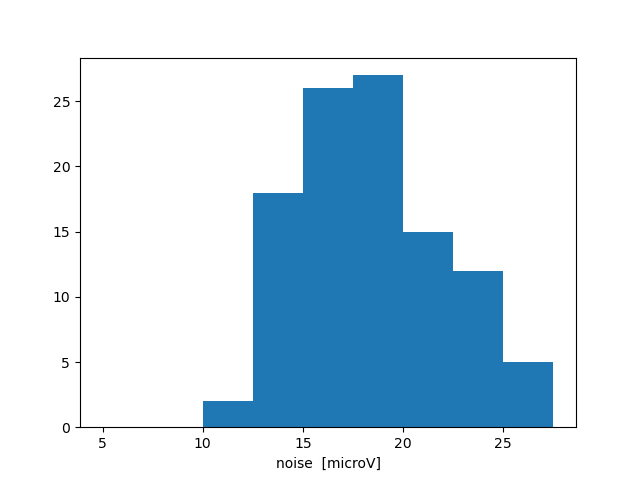

In [5]:
noise_levels_microV = si.get_noise_levels(recording_raw, return_scaled=True)
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [microV]')

In [6]:
# define the preprocessing steps
recording = st.bandpass_filter(recording, freq_min=300, freq_max=6000, dtype='float32') 
recording = st.phase_shift(recording) #lazy
[bad_channel_ids, channel_labels] = st.detect_bad_channels(recording=recording)  # 30 seconds for recording_sub, 32 seconds for the whole recording...
recording = recording.remove_channels(remove_channel_ids=bad_channel_ids)

# split in groups and apply spatial filtering - cmr is a little faster. results are quite similar
grouped_recordings = recording.split_by(property='group')
recgrouplist_hpsf = [st.highpass_spatial_filter(recording=grouped_recordings[k]) for k in grouped_recordings.keys()]
recording_hpsf = si.aggregate_channels(recgrouplist_hpsf)

In [7]:
if save2path.is_dir():
    recording_saved = si.read_zarr(save2path)    # reczarr = si.load_extractor(save2path) #achieve the same...
else:
    #recording_saved = recording_hpsf.save(save2path, **job_kwargs)
    import numcodecs
    compressor = numcodecs.Blosc(cname="zstd", clevel=5, shuffle=numcodecs.Blosc.BITSHUFFLE)
    recording_saved = recording_hpsf.save(format="zarr", folder=save2path,
                                         compressor=compressor,
                                         **job_kwargs)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print("CR custom:", recording_saved.get_annotation("compression_ratio"))

write_zarr_recording with n_jobs = 16 and chunk_size = 30000


write_zarr_recording:   0%|          | 0/6123 [00:00<?, ?it/s]

Elapsed time: 4058.387131214142 seconds
CR custom: 1.125936117988302


detect peaks using locally_exclusive:   0%|          | 0/6123 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/6123 [00:00<?, ?it/s]

Elapsed time: 5026.767864942551 seconds
CR custom: 1.125936117988302


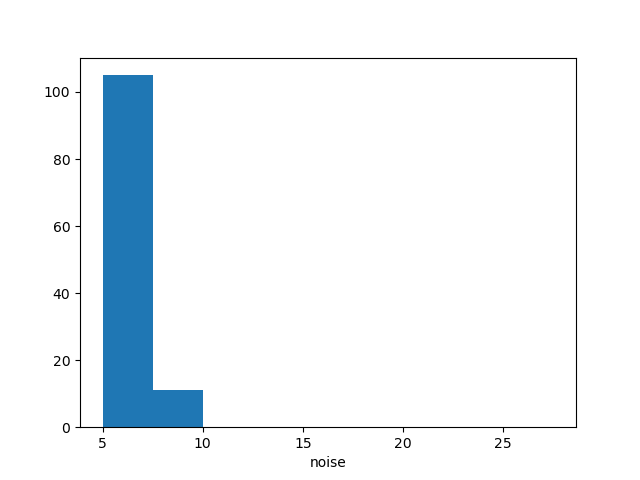

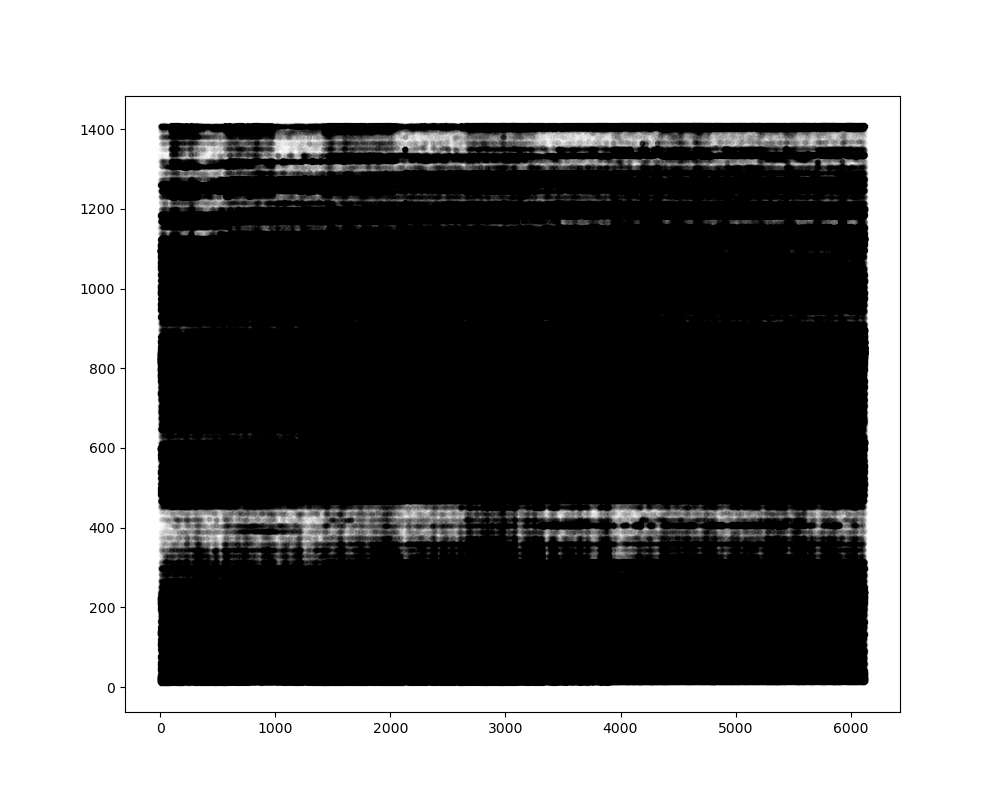

In [8]:
noise_levels_unscaled = si.get_noise_levels(recording_saved, return_scaled=False)
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_unscaled, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise')

from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peaks = detect_peaks(recording_saved,  method='locally_exclusive', noise_levels=noise_levels_unscaled,
                     detect_threshold=5, radius_um=50., **job_kwargs)
peak_locations = localize_peaks(recording_saved, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.02)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print("CR custom:", recording_saved.get_annotation("compression_ratio"))

In [9]:
# # optional module here:
# motion_folder = Path(os.path.join(npxpath, 'motioncorrection'))
# rec_corrected, motion_info = st.correct_motion(recording=recording_saved, preset="nonrigid_accurate", folder=motion_folder, output_motion_info=True, **job_kwargs)
# # motion_info = st.load_motion_info(motion_folder)
# # and plot
# fig = plt.figure(figsize=(14, 8))
# si.plot_motion(motion_info, figure=fig, depth_lim=(400, 600),
#                color_amplitude=True, amplitude_cmap='inferno', scatter_decimate=10)

In [10]:
si.Kilosort3Sorter.set_kilosort3_path(r"C:\Users\SNeurobiology\Documents\MATLAB\kilosort3-master")
# si.get_default_sorter_params('kilosort3')

Setting KILOSORT3_PATH environment variable for subprocess calls to: C:\Users\SNeurobiology\Documents\MATLAB\kilosort3-master


In [ ]:
working_folder = Path(os.path.join(npxpath, 'workingKS'))
params_kilosort3 = {'do_correction': True}

aggregate_sorting = si.run_sorter_by_property(sorter_name='kilosort3', recording=recording_hpsf,
                                           grouping_property='group',
                                           working_folder=working_folder,
                                           docker_image=False, verbose=True, **params_kilosort3)

write_binary_recording:   0%|          | 0/6123 [00:00<?, ?it/s]

In [ ]:
si.run_sorter?

In [13]:
recording_saved

ZarrRecordingExtractor: 383 channels - 30.0kHz - 1 segments - 183,662,661 samples 
                        6,122.09s (1.70 hours) - float32 dtype - 262.05 GiB

In [15]:
recording_raw

OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 183,662,661 samples 
                                   6,122.09s (1.70 hours) - int16 dtype - 131.37 GiB

In [1]:
?recording_hpsf

Object `recording_hpsf` not found.


In [19]:
recording_hpsf.save_to_zarr?